In [13]:
import numpy as np
import h5py

class Layer():
    def __init__(self):
        self.key = "layer" # for easier weight load

    def forward(self, x):
        raise NotImplementedError("Forward method not implemented")

    def load_keras_weights(self, weights):
        raise NotImplementedError("Load Keras weights method not implemented")

    @staticmethod
    def _get_activation(name):
        if name == "relu":
            return lambda x: np.maximum(0, x)
        elif name == "sigmoid":
            return lambda x: 1 / (1 + np.exp(-x))
        elif name == "tanh":
            return np.tanh
        elif name == "softmax":
            def softmax(x):
                e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
                return e_x / np.sum(e_x, axis=-1, keepdims=True)
            return softmax
        elif name is None:
            return lambda x: x
        else:
            raise ValueError(f"Unknown activation function '{name}'")

CONV2D

In [14]:
class Conv2D(Layer):
    def __init__(self, name, filters, kernel_size, strides=(1, 1), padding='valid', groups=1, activation=None):
        super().__init__(name)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.strides = strides
        self.padding = padding.lower()
        self.groups = groups
        self.activation = activation
        self.weights = None
        self.bias = None

    def set_weights(self, weights):
        self.weights = weights[0]
        self.bias = weights[1]

    def _pad_input(self, input):
        if self.padding == 'valid':
            return input
        elif self.padding == 'same':
            in_h, in_w = input.shape[1:3]
            pad_h = max((in_h - 1) * self.strides[0] + self.kernel_size[0] - in_h, 0)
            pad_w = max((in_w - 1) * self.strides[1] + self.kernel_size[1] - in_w, 0)
            pad_top = pad_h // 2
            pad_bottom = pad_h - pad_top
            pad_left = pad_w // 2
            pad_right = pad_w - pad_left
            return np.pad(input, ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant')
        else:
            raise ValueError(f"Tipe padding tidak valid: {self.padding}")

    def _apply_activation(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        return x

    def forward(self, input):
        batch_size = input.shape[0]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        input_padded = self._pad_input(input)
        padded_h, padded_w = input_padded.shape[1:3]

        out_h = (padded_h - kernel_h) // stride_h + 1
        out_w = (padded_w - kernel_w) // stride_w + 1

        output = np.zeros((batch_size, out_h, out_w, self.filters))

        for b in range(batch_size):
            for f in range(self.filters):
                kernel = self.weights[:, :, :, f]
                bias = self.bias[f]
                for i in range(out_h):
                    for j in range(out_w):
                        h_start = i * stride_h
                        h_end = h_start + kernel_h
                        w_start = j * stride_w
                        w_end = w_start + kernel_w

                        patch = input_padded[b, h_start:h_end, w_start:w_end, :]
                        output[b, i, j, f] = np.sum(patch * kernel) + bias

        self.key = "layer"
        return self._apply_activation(output)


POOLING

In [15]:
class MaxPooling1D(Layer):
    def __init__(self, pool_size=2, strides=None, padding="valid"):
        self.pool_size = pool_size
        self.strides = strides if strides is not None else pool_size
        self.padding = padding

    def forward(self, input):
        batch_size, steps, features = input.shape
        output_len = (steps - self.pool_size) // self.strides + 1
        output = np.zeros((batch_size, output_len, features))

        for b in range(batch_size):
            for i in range(output_len):
                start = i * self.strides
                end = start + self.pool_size
                output[b, i, :] = np.max(input[b, start:end, :], axis=0)

        return output


class MaxPooling2D(Layer):
    def __init__(self, pool_size=2, strides=None, padding="valid"):
        self.pool_size = pool_size if isinstance(pool_size, tuple) else (pool_size, pool_size)
        self.strides = strides if strides is not None else self.pool_size
        self.padding = padding

    def forward(self, input):
        batch_size, h, w, c = input.shape
        kh, kw = self.pool_size
        sh, sw = self.strides
        out_h = (h - kh) // sh + 1
        out_w = (w - kw) // sw + 1
        output = np.zeros((batch_size, out_h, out_w, c))

        for b in range(batch_size):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * sh
                    h_end = h_start + kh
                    w_start = j * sw
                    w_end = w_start + kw
                    output[b, i, j, :] = np.max(input[b, h_start:h_end, w_start:w_end, :], axis=(0, 1))

        return output


class AveragePooling1D(Layer):
    def __init__(self, pool_size=2, strides=None, padding="valid"):
        self.pool_size = pool_size
        self.strides = strides if strides is not None else pool_size
        self.padding = padding

    def forward(self, input):
        batch_size, steps, features = input.shape
        output_len = (steps - self.pool_size) // self.strides + 1
        output = np.zeros((batch_size, output_len, features))

        for b in range(batch_size):
            for i in range(output_len):
                start = i * self.strides
                end = start + self.pool_size
                output[b, i, :] = np.mean(input[b, start:end, :], axis=0)

        return output


class AveragePooling2D(Layer):
    def __init__(self, pool_size=2, strides=None, padding="valid"):
        self.pool_size = pool_size if isinstance(pool_size, tuple) else (pool_size, pool_size)
        self.strides = strides if strides is not None else self.pool_size
        self.padding = padding

    def forward(self, input):
        batch_size, h, w, c = input.shape
        kh, kw = self.pool_size
        sh, sw = self.strides
        out_h = (h - kh) // sh + 1
        out_w = (w - kw) // sw + 1
        output = np.zeros((batch_size, out_h, out_w, c))

        for b in range(batch_size):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * sh
                    h_end = h_start + kh
                    w_start = j * sw
                    w_end = w_start + kw
                    output[b, i, j, :] = np.mean(input[b, h_start:h_end, w_start:w_end, :], axis=(0, 1))

        return output


class GlobalAveragePooling1D(Layer):
    def forward(self, input):
        return np.mean(input, axis=1)


class GlobalMaxPooling1D(Layer):
    def forward(self, input):
        return np.max(input, axis=1)


class GlobalAveragePooling2D(Layer):
    def forward(self, input):
        return np.mean(input, axis=(1, 2))


class GlobalMaxPooling2D(Layer):
    def forward(self, input):
        return np.max(input, axis=(1, 2))

FLATTEN

In [16]:
class Flatten(Layer):
    def __init__(self):
        self.key = "flatten"

    def forward(self, input):
        self.input_shape = input.shape
        return input.reshape(input.shape[0], -1)


In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

def load_flattened_image_dataset(csv_path, img_shape=(32, 32), num_channels=1):
    df = pd.read_csv(csv_path)
    data = df.values.astype(np.float32)  # Convert to float32

    # Hitung jumlah sampel
    num_samples = data.shape[0]

    # Reshape dan normalisasi ke range [0, 1]
    images = data.reshape((num_samples, *img_shape, num_channels)) / 255.0

    return images


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


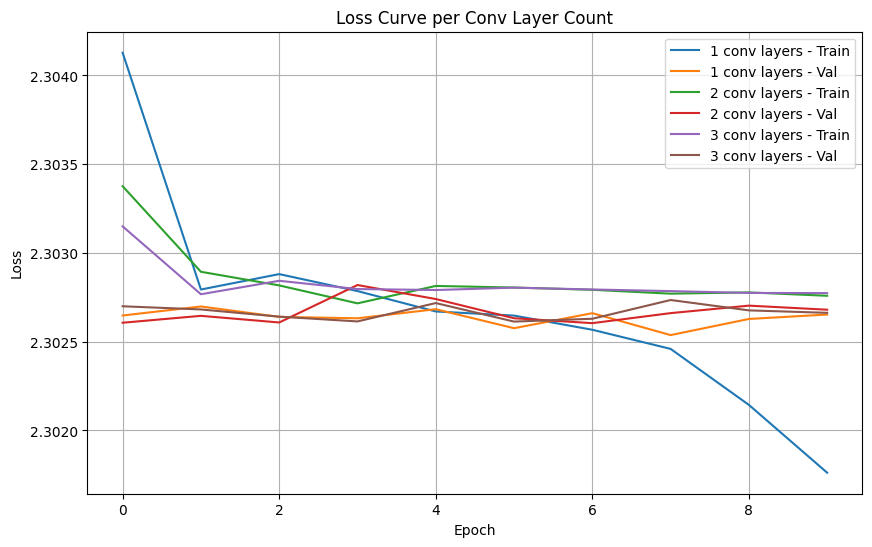

1 conv layers => F1-score: 0.0182
2 conv layers => F1-score: 0.0181
3 conv layers => F1-score: 0.0179
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd

# --- Load Custom Dataset ---
# !pip install gdown
# import gdown

# # Download and load properly
# gdown.download('https://drive.google.com/uc?id=1QVOS-5j25Oh9jW6VSCVRW7WtQbzolbJj', 'train.csv', quiet=False)
# gdown.download('https://drive.google.com/uc?id=1kcqkQ1un7cUSbQuDdlpHJGMP9ZQdbL5C', 'valid.csv', quiet=False)
# gdown.download('https://drive.google.com/uc?id=1BRd6No19q2egduTGiZoDc4xFx5fAt5cn', 'test.csv', quiet=False)

def preprocess_data(df):
    X = df.iloc[:, :-1].values.reshape(-1, 32, 32, 1).astype('float32') / 255.0
    X = np.repeat(X, 3, axis=-1)
    y = df.iloc[:, -1].astype('int64').values

    min_samples = min(X.shape[0], y.shape[0])
    X = X[:min_samples]
    y = y[:min_samples]

    return X, y

train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')
test = pd.read_csv('test.csv')

import os
os.makedirs('models', exist_ok=True)

X_train, y_train = preprocess_data(train)
X_val, y_val = preprocess_data(valid)
X_test, y_test = preprocess_data(test)

# --- Build CNN Model ---
def build_cnn_model(conv_layers=2, filters=[32, 64], kernel_size=(3, 3), pooling='max'):
    model = models.Sequential([layers.Input(shape=(32, 32, 3))])
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters[i] if i < len(filters) else 32, kernel_size, activation='relu', padding='same', name=f'conv2d_{i}'))
        if pooling == 'max':
            model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
        elif pooling == 'avg':
            model.add(layers.AveragePooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', name='dense'))
    model.add(layers.Dense(10, activation='softmax', name='dense_1'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Train and Evaluate ---
def train_and_evaluate(X_train, y_train, X_val, y_val, model):
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    y_pred = np.argmax(model.predict(X_val), axis=1)
    f1 = f1_score(y_val, y_pred, average='macro')
    return history, f1

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp / np.sum(exp, axis=-1, keepdims=True)

# --- Plot Loss ---
def plot_loss(history, label):
    plt.plot(history.history['loss'], label=f'{label} - Train')
    plt.plot(history.history['val_loss'], label=f'{label} - Val')

# --- Hyperparameter Experiments ---
def experiment_hyperparameters():
    # Experiment: Number of Conv Layers
    plt.figure(figsize=(10, 6))
    results = []
    for n_layer in [1, 2, 3]:
        filters = [32] * n_layer
        model = build_cnn_model(conv_layers=n_layer, filters=filters)
        history, f1 = train_and_evaluate(X_train, y_train, X_val, y_val, model)
        plot_loss(history, f'{n_layer} conv layers')
        results.append((f'{n_layer} conv layers', f1))
        model.save_weights(f'models/model_conv_{n_layer}.weights.h5')
    plt.legend()
    plt.title("Loss Curve per Conv Layer Count")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    for desc, score in results:
        print(f"{desc} => F1-score: {score:.4f}")

    # Experiment: Number of Filters
    plt.figure(figsize=(10, 6))
    results = []
    for filters in [[32, 64], [64, 128], [128, 256]]:
        model = build_cnn_model(conv_layers=2, filters=filters)
        history, f1 = train_and_evaluate(X_train, y_train, X_val, y_val, model)
        plot_loss(history, f'Filters: {filters}')
        results.append((f'Filters: {filters}', f1))
        model.save_weights(f'models/model_filters_{filters[0]}_{filters[1]}.weights.h5')
    plt.legend()
    plt.title("Loss Curve per Filter Configuration")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    for desc, score in results:
        print(f"{desc} => F1-score: {score:.4f}")

    # Experiment: Kernel Size
    plt.figure(figsize=(10, 6))
    results = []
    for kernel_size in [(3, 3), (5, 5), (7, 7)]:
        model = build_cnn_model(conv_layers=2, filters=[32, 64], kernel_size=kernel_size)
        history, f1 = train_and_evaluate(X_train, y_train, X_val, y_val, model)
        plot_loss(history, f'Kernel Size: {kernel_size}')
        results.append((f'Kernel Size: {kernel_size}', f1))
        model.save_weights(f'models/model_kernel_{kernel_size[0]}x{kernel_size[1]}.weights.h5')
    plt.legend()
    plt.title("Loss Curve per Kernel Size")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    for desc, score in results:
        print(f"{desc} => F1-score: {score:.4f}")

    # Experiment: Pooling Type
    plt.figure(figsize=(10, 6))
    results = []
    for pooling in ['max', 'avg']:
        model = build_cnn_model(conv_layers=2, filters=[32, 64], pooling=pooling)
        history, f1 = train_and_evaluate(X_train, y_train, X_val, y_val, model)
        plot_loss(history, f'Pooling: {pooling}')
        results.append((f'Pooling: {pooling}', f1))
        model.save_weights(f'models/model_pooling_{pooling}.weights.h5')
    plt.legend()
    plt.title("Loss Curve per Pooling Type")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    for desc, score in results:
        print(f"{desc} => F1-score: {score:.4f}")

# --- Forward Propagation from Scratch ---
def load_weights(h5_path):
    weights = {}
    with h5py.File(h5_path, 'r') as f:
        for layer_name in f.keys():
            layer = f[layer_name]
            w = layer['kernel:0'][()]
            w = layer.get('kernel:0', None)
            b = layer.get('bias:0', None)
            if w is None or b is None:
                raise KeyError(f"Missing weights or bias for layer '{layer_name}'")
    return weights


def forward_from_scratch(X, weights, conv_layers=2, filters=[32, 64], kernel_size=(3, 3), pooling='max'):
    preds = []
    for i in range(X.shape[0]):
        x = X[i]
        for l in range(conv_layers):
            w, b = weights[f'conv2d_{l}']
            conv = Conv2D(name=f'conv2d_{l}', filters=filters[l], kernel_size=kernel_size, strides=(1, 1), padding='same', activation='relu')
            conv.set_weights((w, b))
            x = conv.forward(x)
            pool = MaxPooling2D(pool_size=(2, 2), strides=2) if pooling == 'max' else AveragePooling2D(pool_size=(2, 2), strides=2)
            x = pool.forward(x)
        x = Flatten().forward(x)
        w1, b1 = weights['dense']
        x = relu(np.dot(x, w1) + b1)
        w2, b2 = weights['dense_1']
        x = softmax(np.dot(x, w2) + b2)
        preds.append(np.argmax(x))
    return np.array(preds)

# # --- Run Experiments ---
experiment_hyperparameters()

# --- Test Forward Propagation ---
weights = load_weights('models/model_conv_2.weights.h5')
manual_preds = forward_from_scratch(X_test, weights, conv_layers=2, filters=[32, 64])
keras_model = build_cnn_model(conv_layers=2, filters=[32, 64])
keras_model.load_weights('models/model_conv_2.weights.h5')
keras_preds = np.argmax(keras_model.predict(X_test), axis=1)

manual_f1 = f1_score(y_test, manual_preds, average='macro')
keras_f1 = f1_score(y_test, keras_preds, average='macro')
print(f"Manual Forward F1: {manual_f1:.4f}, Keras Forward F1: {keras_f1:.4f}")